In [1460]:
# |exporti

# imports to be used in .py file
import streamlit as st
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [1461]:
# imports to be used in .ipynb file
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from nbdev.export import nb_export
from streamlit_jupyter import StreamlitPatcher, tqdm

In [1462]:
# allows for Streamlit code to work within jupyter notebook
sp = StreamlitPatcher()
sp.jupyter()  # register patcher with streamlit

In [1463]:
# |exporti

# create title for web app
st.title(":blue[Fanz O' Filmz] Movie Recommender")

# :blue[Fanz O' Filmz] Movie Recommender

### Import data and prepare data for exploring

In [1464]:
# |exporti 

# import data to dataframe
df = pd.read_csv('data/IMDb_All_Genres_etf_clean1.csv')

In [1465]:
# |exporti

# create copy of dataframe for editing to prevent errors, selecting features used for recommendations
movies = df[['Movie_Title', 'Year', 'Director', 'Actors', 'main_genre', 'side_genre']].copy()

In [1466]:
# |exporti

# function to combine genre columns
def combine_genres(data):
    comb_genres = []
    for i in range(0, data.shape[0]):
        comb_genres.append(data['main_genre'][i] + ' ' + data['side_genre'][i])
        
    return comb_genres

In [1467]:
# |exporti

# prepare column for combination
movies['side_genre'] = movies['side_genre'].str.replace(",","")

In [1468]:
# |exporti

# combine genre columns
movies['genres'] = combine_genres(movies)

In [1469]:
# |exporti

# drop original genre columns - no longer needed
movies = movies.drop(columns = ['main_genre', 'side_genre'])

In [1470]:
# |exporti

# combine Movie_Title and Year columns to make unique titles in the case of different movies having the same name
def get_clean_title(data):
    clean_title = []
    for i in range(0, data.shape[0]):
        clean_title.append(data['Movie_Title'][i] + ' (' + str(data['Year'][i]) + ')')
        
    return clean_title

In [1471]:
# |exporti

# create clean_title column
movies['clean_title'] = get_clean_title(movies)

In [1472]:
# check for duplicate films
movies['clean_title'].is_unique

False

In [1473]:
# |exporti

# remove duplicate rows from dataframe
movies = movies.drop_duplicates(subset = ['clean_title']).copy()

In [1474]:
# confirm duplicates are removed
movies['clean_title'].is_unique

True

In [1475]:
# |exporti

# reset indices in dataframe to clear empty duplicate indexes
movies.reset_index(inplace = True, drop = True)

In [1476]:
movies.head()

,Movie_Title,Year,Director,Actors,genres,clean_title
0,Kantara,2022,Rishab Shetty,"Rishab Shetty, Sapthami Gowda, Kishore Kumar G...",Action Adventure Drama,Kantara (2022)
1,The Dark Knight,2008,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",Action Crime Drama,The Dark Knight (2008)
2,The Lord of the Rings: The Return of the King,2003,Peter Jackson,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or...",Action Adventure Drama,The Lord of the Rings: The Return of the King ...
3,Inception,2010,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",Action Adventure Sci-Fi,Inception (2010)
4,The Lord of the Rings: The Two Towers,2002,Peter Jackson,"Elijah Wood, Ian McKellen, Viggo Mortensen, Or...",Action Adventure Drama,The Lord of the Rings: The Two Towers (2002)


In [1477]:
# |exporti

# prepare columns then split into lists
movies['Director'] = movies["Director"].str.replace("Directors:", "")
movies['Director'] = movies['Director'].map(lambda x: x.replace(" ", "").lower().split(',')[:3])

movies['Actors'] = movies['Actors'].map(lambda x: x.replace(" ", "").lower().split(',')[:4])

movies['genres'] = movies['genres'].map(lambda x: x.lower().split())

In [1480]:
movies.head()

,Movie_Title,Year,Director,Actors,genres,clean_title
0,Kantara,2022,[rishabshetty],"[rishabshetty, sapthamigowda, kishorekumarg., ...","[action, adventure, drama]",Kantara (2022)
1,The Dark Knight,2008,[christophernolan],"[christianbale, heathledger, aaroneckhart, mic...","[action, crime, drama]",The Dark Knight (2008)
2,The Lord of the Rings: The Return of the King,2003,[peterjackson],"[elijahwood, viggomortensen, ianmckellen, orla...","[action, adventure, drama]",The Lord of the Rings: The Return of the King ...
3,Inception,2010,[christophernolan],"[leonardodicaprio, josephgordon-levitt, elliot...","[action, adventure, sci-fi]",Inception (2010)
4,The Lord of the Rings: The Two Towers,2002,[peterjackson],"[elijahwood, ianmckellen, viggomortensen, orla...","[action, adventure, drama]",The Lord of the Rings: The Two Towers (2002)


### Explore the data

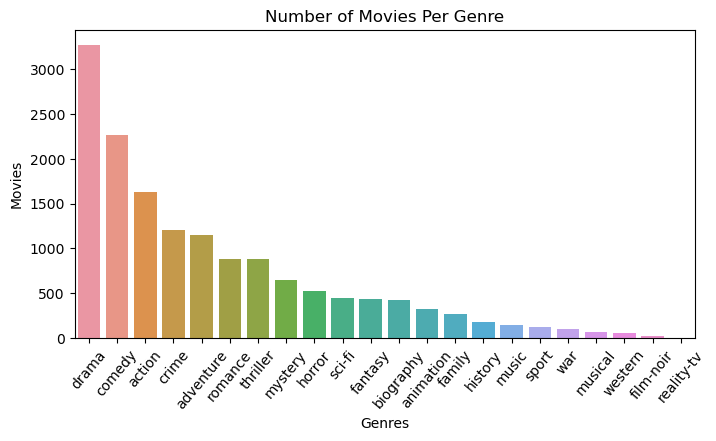

In [1508]:
# count number of genre occurrences
genre_counter = Counter(g for genres in movies['genres'] for g in genres)

# create dataframe to plot genre count data
genre_counter_df = pd.DataFrame([genre_counter]).T.reset_index()
genre_counter_df.columns = ['Genres', 'Movies']
genre_counter_df = genre_counter_df.sort_values(by = 'Movies', ascending=False)

fig = plt.figure(figsize=(8,4))
sns.barplot(x = 'Genres', y = 'Movies', data = genre_counter_df)
plt.title("Number of Movies Per Genre")
plt.xticks(rotation = 50)
plt.show()

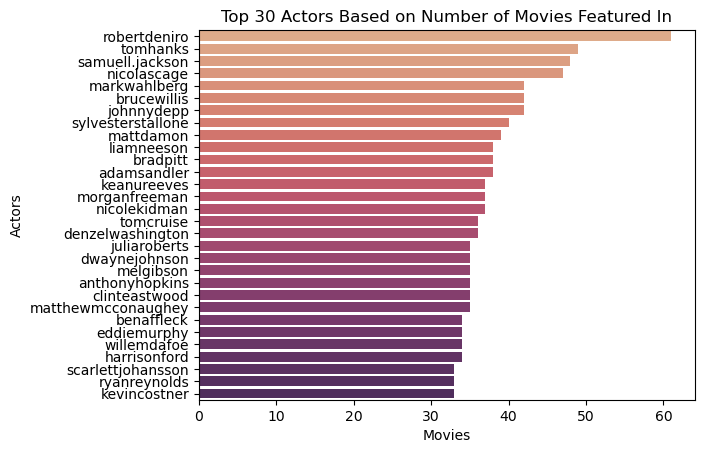

In [1501]:
# count number of movies an actor is featured in
actor_counter = Counter(a for actors in movies['Actors'] for a in actors)

# create dataframe to plot top 30 actor/movie data
actor_counter_df = pd.DataFrame([actor_counter]).T.reset_index()
actor_counter_df.columns = ['Actors', 'Movies']
actor_counter_df = actor_counter_df.sort_values(by = 'Movies', ascending = False)

sns.barplot(data = actor_counter_df.head(30), x = 'Movies', y = 'Actors', palette = 'flare')
plt.title("Top 30 Actors Based on Number of Movies Featured In")
plt.show()

In [1490]:
# |exporti

# initialize variable and create function to round year down to find decade of movie release
y = 2003

def round_down(year):
    return year - (year % 10)

In [1489]:
# test function
round_down(y)

2000

In [1491]:
# |exporti

# create decade column based on movie release year
movies['decade'] = movies['Year'].apply(round_down)

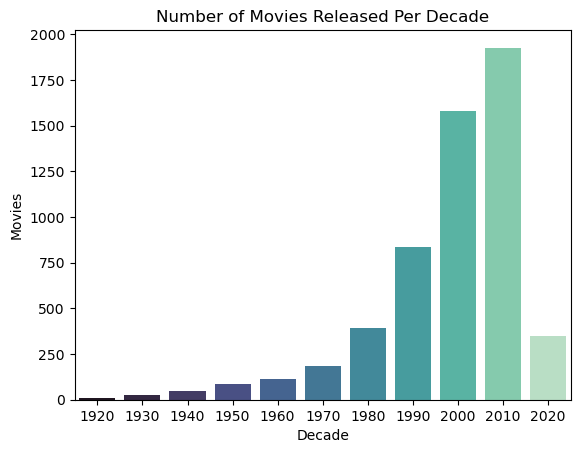

In [1509]:
# plot to count the number of movies released in each decade
sns.countplot(x = movies['decade'], palette = 'mako')
plt.ylabel("Movies")
plt.xlabel("Decade")
plt.title("Number of Movies Released Per Decade");

In [1510]:
# |exporti

# join on columns to turn them into strings
movies['Director'] = movies['Director'].str.join(" ")

movies['Actors'] = movies['Actors'].str.join(" ")

movies['genres'] = movies['genres'].str.join(" ")

In [1511]:
movies.head()

,Movie_Title,Year,Director,Actors,genres,clean_title,decade
0,Kantara,2022,rishabshetty,rishabshetty sapthamigowda kishorekumarg. achy...,action adventure drama,Kantara (2022),2020
1,The Dark Knight,2008,christophernolan,christianbale heathledger aaroneckhart michael...,action crime drama,The Dark Knight (2008),2000
2,The Lord of the Rings: The Return of the King,2003,peterjackson,elijahwood viggomortensen ianmckellen orlandob...,action adventure drama,The Lord of the Rings: The Return of the King ...,2000
3,Inception,2010,christophernolan,leonardodicaprio josephgordon-levitt elliotpag...,action adventure sci-fi,Inception (2010),2010
4,The Lord of the Rings: The Two Towers,2002,peterjackson,elijahwood ianmckellen viggomortensen orlandob...,action adventure drama,The Lord of the Rings: The Two Towers (2002),2000


In [1512]:
# |exporti

# combine feature columns into a single column to use as corpus
def combine_features(data):
    combined_features = []
    for i in range(0, data.shape[0]):
        combined_features.append(str(data['decade'][i]) + ' ' +
                                 data['genres'][i] + ' ' +
                                 data['Actors'][i] + ' ' +
                                 data['Director'][i])
        
    return combined_features

In [1513]:
# |exporti

# create the combined_feature column
movies['combined_features'] = combine_features(movies)

In [1514]:
movies.head()

,Movie_Title,Year,Director,Actors,genres,clean_title,decade,combined_features
0,Kantara,2022,rishabshetty,rishabshetty sapthamigowda kishorekumarg. achy...,action adventure drama,Kantara (2022),2020,2020 action adventure drama rishabshetty sapth...
1,The Dark Knight,2008,christophernolan,christianbale heathledger aaroneckhart michael...,action crime drama,The Dark Knight (2008),2000,2000 action crime drama christianbale heathled...
2,The Lord of the Rings: The Return of the King,2003,peterjackson,elijahwood viggomortensen ianmckellen orlandob...,action adventure drama,The Lord of the Rings: The Return of the King ...,2000,2000 action adventure drama elijahwood viggomo...
3,Inception,2010,christophernolan,leonardodicaprio josephgordon-levitt elliotpag...,action adventure sci-fi,Inception (2010),2010,2010 action adventure sci-fi leonardodicaprio ...
4,The Lord of the Rings: The Two Towers,2002,peterjackson,elijahwood ianmckellen viggomortensen orlandob...,action adventure drama,The Lord of the Rings: The Two Towers (2002),2000,2000 action adventure drama elijahwood ianmcke...


### Apply Content-Based Filtering model by vectorizing data and measuring cosine similarity between movies

In [1527]:
# |exporti

# vectorize the combined_features column and transform into a matrix
vec = TfidfVectorizer()
vec_matrix = vec.fit_transform(movies['combined_features'])

In [1528]:
# |exporti

# get cosine similarity maxtrix from the vectorized matrix
cs = cosine_similarity(vec_matrix)

In [1531]:
# |exporti

# finds index of user-chosen movie, then provides a sorted list based on the
# cosine similarity distance between other movies and recommends the top 5 matches
def recommend(movie):
    movie_index = movies[movies['clean_title'] == movie].index[0]
    cs_distances = cs[movie_index]
    movie_list = sorted(list(enumerate(cs_distances)), reverse = True, key = lambda x: x[1])[1:6]

    recommended_movies = []
    for i in movie_list:
        recommended_movies.append(movies.iloc[i[0]].clean_title)

    return recommended_movies

In [1532]:
recommend("The Avengers (2012)")

['Avengers: Age of Ultron (2015)',
 'Captain America: Civil War (2016)',
 'Avengers: Infinity War (2018)',
 'Captain America: The Winter Soldier (2014)',
 'Avengers: Endgame (2019)']

In [1450]:
# |exporti

# provides a Streamlit selection box for the user to select a movie
selected_movie_name = st.selectbox('Please select a movie you enjoy:', movies['clean_title'].values)

Dropdown(description='Please select a movie you enjoy:', options=('Kantara (2022)', 'The Dark Knight (2008)', …

In [1451]:
# |exporti

# creates a Streamlit recommendation button that when clicked will provide 
# the user with movie recommendations based on the chosen movie
if st.button('Get Recommendations'):
    recommendations = recommend(selected_movie_name)
    st.write(":blue[Based on your selection, we recommend the following movies:]")
    for j in recommendations:
        st.write(j)

In [1533]:
# exports all code snippets with the "|exporti" comment to a .py file
# for use as a Streamlit web app
nb_export("movie-rec.ipynb", lib_path = "./", name = "movie-rec")

##### Please click the button to open the interactive web app: [![Open in Streamlit](https://static.streamlit.io/badges/streamlit_badge_black_white.svg)](https://sunlongan-testmovierec2-testmovierec2-9ranf7.streamlit.app/)